Original:

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb

Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify {}. Can you get to it with a browser?'.format(filename))
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [8]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size {:,d} words'.format(len(words)))

Data size 17,005,207 words


Build the dictionary and replace rare words with UNK token.

In [5]:
%%time

def build_dataset(vocabulary_size, words):
    words_freq = collections.Counter(words).most_common(vocabulary_size - 1)
    word_to_id = dict((word, word_id) for word_id, (word, _) in enumerate(words_freq, 1))
    
    UNK_ID = 0
    word_to_id['UNK'] = UNK_ID

    data = list()
    unk_count = 0
    for word in words:
        word_id = word_to_id.get(word, UNK_ID)
        if word_id == UNK_ID:
            unk_count += 1
        data.append(word_id)

    words_freq = [('UNK', unk_count)] + words_freq

    word_from_id = dict((word_id, word) for word, word_id in word_to_id.items()) 
    
    return data, words_freq, word_to_id, word_from_id


vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary_size, words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

Most common words (+UNK) [('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
CPU times: user 11.8 s, sys: 80 ms, total: 11.9 s
Wall time: 11.9 s


In [9]:
del words  # Hint to reduce memory.

Function to generate a training batch for the skip-gram model.

Input:
 
    pair ( target word, some word around the target)

Words around the target (words to the left and to the right):

    skip_window

Window size:

    skip_window (left) + 1 (target) + skip_window (right) = 2 * skip_window + 1

Different pairs per Window (same target, different word around):

    num_skips

(Example)

    target in the middle, skip_window = 2, num_skips = 4:

    (w1, w2, w3, w4, w5) -> (w3, w1), (w3, w2), (w3, w4), (w3, w5)

    [4 pairs]

Window per Epoch:

    first window starts with window_size words, next window adds one right, removes one left
    
    num_windows = num_words - window_size + 1

Pairs per Epoch:

    epoch_size = num_windows * num_skips

Batch per Epoch:

    num_batches = epoch_size // batch_size
    
    (epoch_size % batch_size pairs are 'ignored')

In [87]:
def context_window(window_words, target_index):
    words = list(window_words)
    del words[target_index]
    return words

def context_sample(context_words, sample_size):
    return random.sample(context_words, sample_size)

def context(window_words, target_index, sample_size, use_sample):
    words = context_window(window_words, target_index)
    if use_sample:
        words = context_sample(words, sample_size) 
    return words

def generate_batch(data, batch_size, num_skips, skip_window):
    if num_skips > 2 * skip_window:
        # It is not possible to generate {num_skips} different pairs
        # with the second word coming from {2 * skip_window} words.
        raise Exception('Invalid parameters: num_skips={}, 2 * skip_window={}'.format(num_skips, 2 * skip_window))

    num_words = len(data)
    window_size = 2 * skip_window + 1
    num_windows = num_words - window_size + 1
    epoch_size = num_windows * num_skips
    num_batches = epoch_size // batch_size
    target_index = skip_window
    use_sample = num_skips < 2 * skip_window
    
    words = collections.deque(data[window_size:])
    window_words = collections.deque(data[:window_size], maxlen=window_size)
    target_word = window_words[target_index]
    context_words = context(window_words, target_index, num_skips, use_sample)
    
    for n in range(num_batches):
        batch = np.ndarray(shape=(batch_size,), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

        for i in range(batch_size):
            batch[i] = target_word
            labels[i, 0] = context_words.pop()
            if not context_words:
                window_words.append(words.popleft())
                target_word = window_words[target_index]
                context_words = context(window_words, target_index, num_skips, use_sample)

        yield batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])


for num_skips, skip_window in [(2, 1), (4, 2)]:
    batch, labels = next(generate_batch(data, batch_size=8, num_skips=num_skips, skip_window=skip_window))
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'a', 'originated', 'anarchism', 'of', 'term', 'as', 'originated']


In [89]:
%%time

n = 0
for _, _ in generate_batch(data, batch_size=128, num_skips=2, skip_window=1):
    n += 1

print('Steps: {:,d}'.format(n))

Steps: 265,706
CPU times: user 51 s, sys: 152 ms, total: 51.1 s
Wall time: 51.1 s


Train a skip-gram model.

In [116]:
def word2vec(vocabulary_size, embedding_size, num_sampled):
    X = tf.placeholder(shape=(None,), dtype=tf.int32)
    y = tf.placeholder(shape=(None, 1), dtype=tf.int32)
    
    embeddings = tf.Variable(
        tf.random_uniform(shape=(vocabulary_size, embedding_size), minval=-1.0, maxval=1.0))
    
    X_embed = tf.nn.embedding_lookup(embeddings, X)
    
    softmax_weights = tf.Variable(
        tf.truncated_normal(shape=(vocabulary_size, embedding_size),
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(
        tf.zeros(shape=(vocabulary_size,)))
    
    sampled_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights,
                                              biases=softmax_biases,
                                              inputs=X_embed,
                                              labels=y,
                                              num_sampled=num_sampled,
                                              num_classes=vocabulary_size)
    loss = tf.reduce_mean(sampled_loss)

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    return X, y, normalized_embeddings, loss, optimizer


class NearestWordsQuery:
    
    def __init__(self, word_from_id, words, k=4):
        self.word_from_id = word_from_id
        self.words = words
        self.k = k

    def build_graph(self, embeddings):
        input_words = tf.placeholder(shape=(None,), dtype=tf.int32)

        input_embed = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(input_embed, embeddings, transpose_b=True)
        nearest = tf.nn.top_k(similarity, self.k+1)

        self.input_words = input_words
        self.nearest = nearest
        
    def run(self, session):
        input_words={self.input_words: self.words}
        nearest_val, nearest_id = session.run(self.nearest, feed_dict=input_words)
        for i, word_id in enumerate(self.words):
            word = self.word_from_id[word_id]
            nearest_pairs = zip(nearest_id[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ('{} ({:,.3f})'.format(self.word_from_id[id_], val_)
                             for id_, val_ in nearest_pairs)
            print('Nearest to {}: {}'.format(word, ', '.join(nearest_words)))


def train(model_fn, input_fn, query, num_epochs):
    with tf.Graph().as_default() as graph, \
        tf.Session(graph = graph) as session:
        
        X, y, embeddings, loss_op, opt = model_fn()
        query.build_graph(embeddings)
        
        tf.global_variables_initializer().run()
        print('Initialized.\n')

        for epoch in range(1, num_epochs+1):
            print('Epoch {}\n'.format(epoch))
            
            avg_loss = 0
            for step, (batch_data, batch_labels) in enumerate(input_fn()):
                feed_dict = {X: batch_data, y: batch_labels}
                _, loss = session.run([opt, loss_op], feed_dict=feed_dict)
                
                avg_loss = (loss + step * avg_loss) / (step + 1)
                if step % 10_000 == 0:
                    print('...{:,d} Avarage loss: {:.3f}'.format(step, avg_loss))
            
            print('\nAvarage loss: {:.3f}\n'.format(avg_loss))
            query.run(session)
            print()
            
        return embeddings.eval()

In [117]:
%%time

vocabulary_size = len(dictionary)
embedding_size = 128 # Dimension of the embedding vector.
num_sampled = 64     # Number of negative examples to sample.

batch_size = 128
skip_window = 1      # How many words to consider left and right.
num_skips = 2        # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 1000 # Only pick dev samples in the head of the distribution.
valid_examples = random.sample(range(1, valid_window), valid_size)

nearest_words = NearestWordsQuery(reverse_dictionary, valid_examples, 4)

final_embeddings = train(lambda: word2vec(vocabulary_size, embedding_size, num_sampled),
                         lambda: generate_batch(data, batch_size, num_skips, skip_window),
                         nearest_words,
                         num_epochs=1)

Initialized.

Epoch 1

...0 Avarage loss: 8.071
...10,000 Avarage loss: 3.858
...20,000 Avarage loss: 3.688
...30,000 Avarage loss: 3.617
...40,000 Avarage loss: 3.572
...50,000 Avarage loss: 3.541
...60,000 Avarage loss: 3.517
...70,000 Avarage loss: 3.491
...80,000 Avarage loss: 3.472
...90,000 Avarage loss: 3.462
...100,000 Avarage loss: 3.449
...110,000 Avarage loss: 3.436
...120,000 Avarage loss: 3.424
...130,000 Avarage loss: 3.414
...140,000 Avarage loss: 3.402
...150,000 Avarage loss: 3.391
...160,000 Avarage loss: 3.384
...170,000 Avarage loss: 3.376
...180,000 Avarage loss: 3.370
...190,000 Avarage loss: 3.363
...200,000 Avarage loss: 3.352
...210,000 Avarage loss: 3.337
...220,000 Avarage loss: 3.332
...230,000 Avarage loss: 3.326
...240,000 Avarage loss: 3.322
...250,000 Avarage loss: 3.312
...260,000 Avarage loss: 3.308

Avarage loss: 3.307

Nearest to ireland: scotland (0.525), spain (0.476), france (0.462), italy (0.452)
Nearest to together: along (0.524), up (0.377), me

In [118]:
%%time

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

CPU times: user 3.73 s, sys: 148 ms, total: 3.88 s
Wall time: 2.75 s


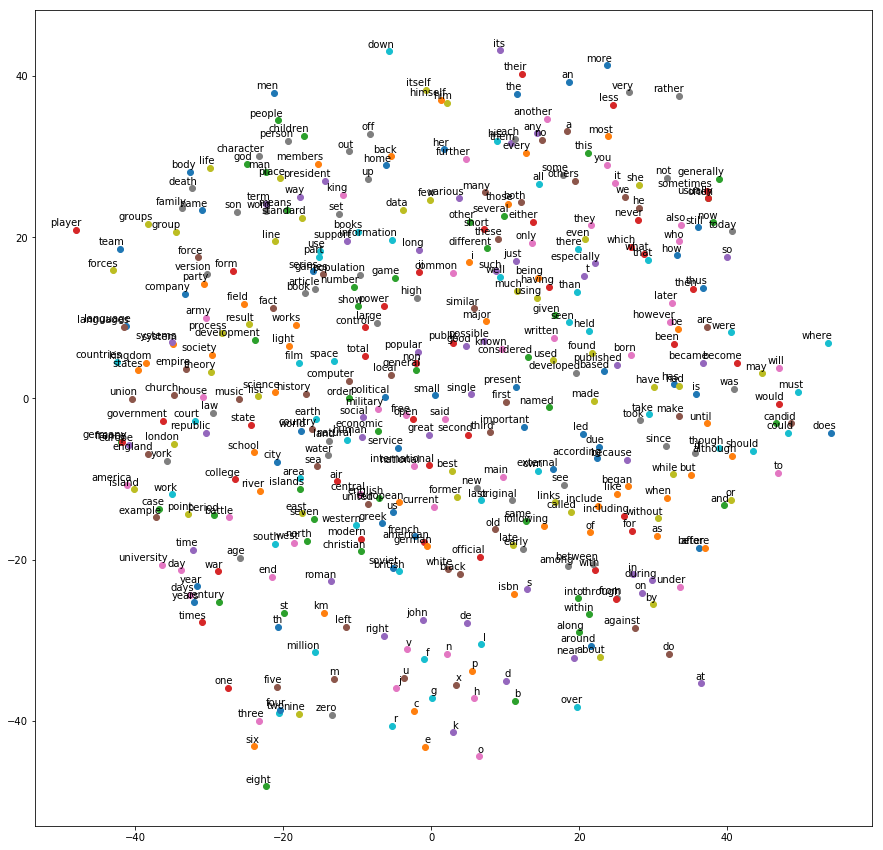

CPU times: user 4.07 s, sys: 68 ms, total: 4.14 s
Wall time: 4.23 s


In [119]:
%%time

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [122]:
graph = tf.Graph()
graph.as_default()
session = tf.InteractiveSession(graph=graph)
session

In [176]:
batch_size = 4
context_size = 2
vocabulary_size = 20
embedding_size = 3

In [177]:
X = tf.constant(np.random.randint(low=0, high=vocabulary_size, size=(batch_size, context_size), dtype=np.int32))

print(X)
X.eval()

Tensor("Const_6:0", shape=(4, 2), dtype=int32)


array([[ 1, 19],
       [14, 10],
       [10, 14],
       [ 5, 17]], dtype=int32)

In [178]:
y = tf.constant(np.random.randint(low=0, high=vocabulary_size, size=(batch_size, 1), dtype=np.int32))

print(y)
y.eval()

Tensor("Const_7:0", shape=(4, 1), dtype=int32)


array([[ 6],
       [ 5],
       [ 8],
       [14]], dtype=int32)

In [179]:
# ~ tf.random_uniform(shape=(vocabulary_size, embedding_size), minval=-1.0, maxval=1.0)
embeddings = tf.Variable(2 * np.random.rand(vocabulary_size, embedding_size) - 1, dtype=tf.float32)

embeddings.initializer.run()

print(embeddings)
embeddings.eval()

<tf.Variable 'Variable_7:0' shape=(20, 3) dtype=float32_ref>


array([[-0.07388918, -0.43258303, -0.00879517],
       [ 0.67343807, -0.07926012,  0.86205721],
       [ 0.15045255, -0.72824562, -0.16198695],
       [-0.62714249, -0.87545466,  0.95475543],
       [-0.97168344,  0.43266761,  0.25614282],
       [ 0.50827312,  0.27151456, -0.63181961],
       [-0.2380048 ,  0.90988463,  0.57533109],
       [ 0.19253886,  0.71993887,  0.95498967],
       [ 0.30223957, -0.02857143,  0.09893961],
       [ 0.03150238, -0.89746171, -0.26942328],
       [-0.09707133, -0.58752304, -0.84316021],
       [-0.90730697, -0.94646329,  0.42381862],
       [-0.29335123,  0.79356903, -0.98610401],
       [ 0.36107981, -0.10785385,  0.12830897],
       [-0.56192714,  0.60322517,  0.56473935],
       [ 0.84270036,  0.23979098,  0.487082  ],
       [-0.04869852, -0.91915673, -0.5226391 ],
       [ 0.80650485, -0.24286535, -0.42026573],
       [-0.39754888, -0.08158838,  0.56348753],
       [-0.22202705,  0.10654906, -0.85060012]], dtype=float32)

In [180]:
X_embed = tf.nn.embedding_lookup(embeddings, X)

print(X_embed)
X_embed.eval()

Tensor("embedding_lookup_2:0", shape=(4, 2, 3), dtype=float32)


array([[[ 0.67343807, -0.07926012,  0.86205721],
        [-0.22202705,  0.10654906, -0.85060012]],

       [[-0.56192714,  0.60322517,  0.56473935],
        [-0.09707133, -0.58752304, -0.84316021]],

       [[-0.09707133, -0.58752304, -0.84316021],
        [-0.56192714,  0.60322517,  0.56473935]],

       [[ 0.50827312,  0.27151456, -0.63181961],
        [ 0.80650485, -0.24286535, -0.42026573]]], dtype=float32)

In [181]:
X_avg = tf.reduce_mean(X_embed, axis=1)

print(X_avg)
X_avg.eval()

Tensor("Mean_8:0", shape=(4, 3), dtype=float32)


array([[ 0.2257055 ,  0.01364447,  0.00572854],
       [-0.32949924,  0.00785106, -0.13921043],
       [-0.32949924,  0.00785106, -0.13921043],
       [ 0.65738899,  0.01432461, -0.5260427 ]], dtype=float32)

In [182]:
c0_w0 = X_embed[0,:,0].eval()
print('first dimension of each embedding verctor of first context:\n\n', c0_w0, '\n')
print('first dimension avarage:\n\n', np.mean(c0_w0))

first dimension of each embedding verctor of first context:

 [ 0.67343807 -0.22202705] 

first dimension avarage:

 0.225706


In [183]:
# ~ tf.truncated_normal(shape=(vocabulary_size, embedding_size), stddev=1.0 / math.sqrt(embedding_size))
W = tf.Variable(np.random.randn(vocabulary_size, embedding_size) / np.sqrt(embedding_size), dtype=tf.float32)

W.initializer.run()

print(W)

<tf.Variable 'Variable_8:0' shape=(20, 3) dtype=float32_ref>


In [184]:
b = tf.Variable(np.zeros(vocabulary_size), dtype=tf.float32)

b.initializer.run()

print(b)

<tf.Variable 'Variable_9:0' shape=(20,) dtype=float32_ref>


In [185]:
sampled_loss = tf.nn.sampled_softmax_loss(weights=W,
                                          biases=b,
                                          inputs=X_avg,
                                          labels=y,
                                          num_sampled=2,
                                          num_classes=vocabulary_size)

print(sampled_loss)
sampled_loss.eval()

Tensor("Reshape_8:0", shape=(4,), dtype=float32)


array([ 0.66438562,  0.85213035,  0.44695726,  0.33126286], dtype=float32)

In [186]:
loss = tf.reduce_mean(sampled_loss)

print(loss)
loss.eval()

Tensor("Mean_9:0", shape=(), dtype=float32)


0.90370989

In [187]:
session.close()
del graph

In [188]:
def word2vec_cbow(vocabulary_size, embedding_size, num_sampled):
    X = tf.placeholder(shape=(None, None), dtype=tf.int32)
    y = tf.placeholder(shape=(None, 1), dtype=tf.int32)
    
    embeddings = tf.Variable(
        tf.random_uniform(shape=(vocabulary_size, embedding_size), minval=-1.0, maxval=1.0))
    
    X_embed = tf.nn.embedding_lookup(embeddings, X)
    X_avg = tf.reduce_mean(X_embed, axis=1)
    
    softmax_weights = tf.Variable(
        tf.truncated_normal(shape=(vocabulary_size, embedding_size),
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(
        tf.zeros(shape=(vocabulary_size,)))
    
    sampled_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights,
                                              biases=softmax_biases,
                                              inputs=X_avg,
                                              labels=y,
                                              num_sampled=num_sampled,
                                              num_classes=vocabulary_size)
    loss = tf.reduce_mean(sampled_loss)

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    return X, y, normalized_embeddings, loss, optimizer

In [195]:
def generate_batch_cbow(data, batch_size, window_size):
    if window_size % 2 == 0 or window_size < 3:
        # {window_size} must be odd: (n words left) target (n words right)
        raise Exception('Invalid parameters: window_size must be odd')

    num_words = len(data)
    num_windows = num_words - window_size + 1 # = epoch_size
    num_batches = num_windows // batch_size
    target_index = window_size // 2
    
    words = collections.deque(data[window_size:])
    window_words = collections.deque(data[:window_size], maxlen=window_size)
    
    for n in range(num_batches):
        batch = np.ndarray(shape=(batch_size, window_size-1), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

        for i in range(batch_size):
            batch[i,:] = context_window(window_words, target_index)
            labels[i, 0] = window_words[target_index]
            window_words.append(words.popleft())

        yield batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]], '\n')

for window_size in [3, 5]:
    print('Window size = {}\n'.format(window_size))
    batch_context, batch_target = next(generate_batch_cbow(data, batch_size=2, window_size=window_size))
    for i in range(2):
        context_words = ', '.join(reverse_dictionary[word_id] for word_id in batch_context[i,:])
        target_word = reverse_dictionary[batch_target[i,0]]
        print('[', i, '] Context:\n\n', context_words, '\n')
        print('[', i, '] Target: \n\n', target_word, '\n')

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'] 

Window size = 3

[ 0 ] Context:

 anarchism, as 

[ 0 ] Target: 

 originated 

[ 1 ] Context:

 originated, a 

[ 1 ] Target: 

 as 

Window size = 5

[ 0 ] Context:

 anarchism, originated, a, term 

[ 0 ] Target: 

 as 

[ 1 ] Context:

 originated, as, term, of 

[ 1 ] Target: 

 a 



In [197]:
%%time

n = 0
for _, _ in generate_batch_cbow(data, batch_size=128, window_size=3):
    n += 1

print('Steps: {:,d}'.format(n))

Steps: 132,853
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 14s


In [199]:
%%time

vocabulary_size = len(dictionary)
embedding_size = 128 # Dimension of the embedding vector.
num_sampled = 64     # Number of negative examples to sample.

batch_size = 128
window_size = 3      # How many words to consider per window (left, target and right).

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 1000 # Only pick dev samples in the head of the distribution.
valid_examples = random.sample(range(1, valid_window), valid_size)

nearest_words = NearestWordsQuery(reverse_dictionary, valid_examples, 4)

final_embeddings = train(lambda: word2vec_cbow(vocabulary_size, embedding_size, num_sampled),
                         lambda: generate_batch_cbow(data, batch_size, window_size),
                         nearest_words,
                         num_epochs=1)

Initialized.

Epoch 1

...0 Avarage loss: 7.980
...10,000 Avarage loss: 3.443
...20,000 Avarage loss: 3.271
...30,000 Avarage loss: 3.184
...40,000 Avarage loss: 3.117
...50,000 Avarage loss: 3.075
...60,000 Avarage loss: 3.034
...70,000 Avarage loss: 2.998
...80,000 Avarage loss: 2.968
...90,000 Avarage loss: 2.943
...100,000 Avarage loss: 2.915
...110,000 Avarage loss: 2.886
...120,000 Avarage loss: 2.869
...130,000 Avarage loss: 2.847

Avarage loss: 2.844

Nearest to his: her (0.848), their (0.672), my (0.522), its (0.516)
Nearest to re: allegro (0.353), menial (0.352), screws (0.334), kao (0.328)
Nearest to album: grayson (0.418), band (0.417), movie (0.390), film (0.367)
Nearest to the: its (0.427), his (0.425), their (0.420), this (0.366)
Nearest to treaty: clash (0.415), extermination (0.346), agreement (0.345), plenty (0.343)
Nearest to career: work (0.424), reputation (0.385), life (0.375), novels (0.351)
Nearest to published: introduced (0.523), performed (0.502), released (0

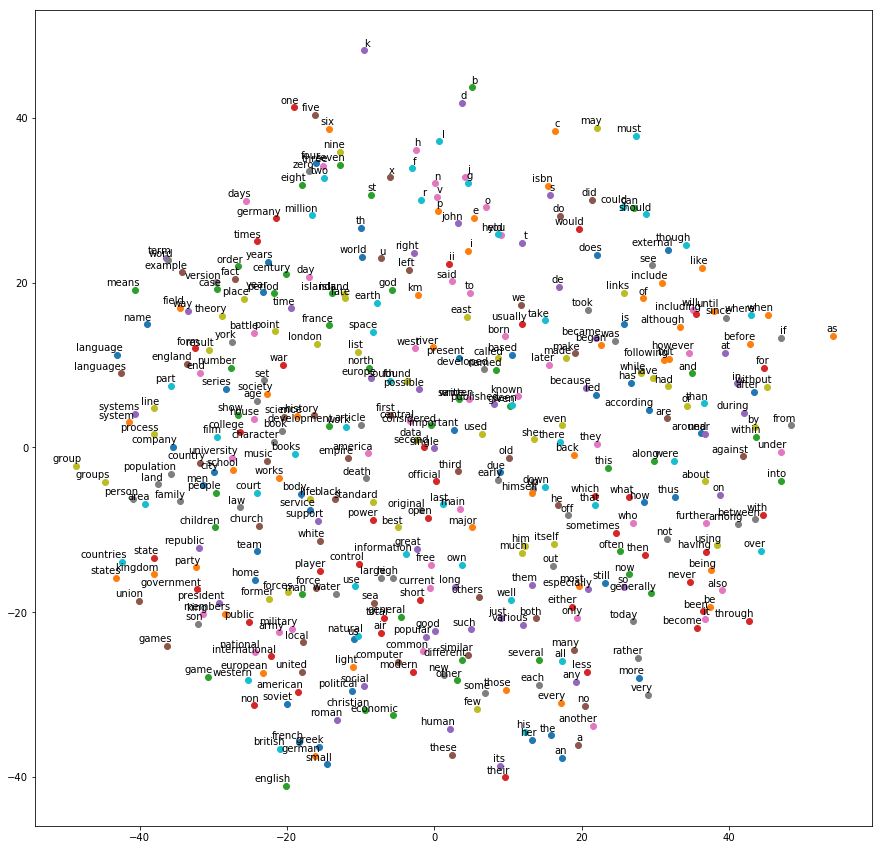

In [200]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)